Generator, Discriminator, Me.
Discriminator: do the numbers come from me or the generator (my job is to pass numbers to the discriminator, while the generator generates scribbles and sends them to the discriminator). The discriminator gets a reward when it realises numbers come from me. 
The generator gets a reward when he sends numbers to the discriminator and the discriminator mistakes its numbers for my numbers. 

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time

Import the keras MNIST dataset and split it into train and test.

In [2]:
mnist = tf.keras.datasets.mnist

In [3]:
(train_images, train_labels), (test_images,test_labels) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


We print the first image of the train dataset.

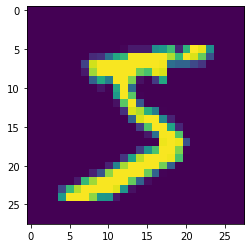

In [4]:
plt.imshow(train_images[0])

How do we want to work with the data? If we look at the train images, we see that these images are defined by arrays containing integers (int8) between 0 and 255:

In [5]:
train_images[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

The first thing we will do is to normalise these arrays so that the images can fit into the neural network that we are going to make. First, we are going to use the function reshape (current shape: (28,28):

In [6]:
#train_images[0].shape out:(28, 28)

In [7]:
train_images = train_images.reshape(train_images.shape[0],28,28,1)

We want to also normalise the data, so that the data is between -1 and 1. In this way, when we put the random numbers from the generator, it will actually be the same item, same range.

In [8]:
train_images = (train_images-127.5)/127.5

We are going to slice images and shuffle them given a buffer size that is equal to the size of the train dataset to have perfect shuffling. Then we batch it: how many images per batch do we want?

In [9]:
BUFFER_SIZE = train_images.shape[0] #size of train: how many of the images we want to shuffle from
BATCH_SIZE = 100
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Now train images is an iterable tf dataset with batch size 100 that has been shuffled from images.

## DISCRIMINATOR MODEL
Categorisation model.
Output: number between 0 and 1, which tells that the probability of this number is a fake one or a real one (taken from dataset or generated  by generator).
Simple: one convolution layer (7 kernels/filters, padding same, input shape = (28,28,1), 1 is the channel),  and two dense layers. In between the dense and the convolution layers, we put a flatten layer. To add some nonlinearity we add a LeakyReLU layer.

In [10]:
def make_discriminator_model():
  model = tf.keras.Sequential() # it is a sequential model
  model.add(tf.keras.layers.Conv2D(7, (3,3), padding = "same", input_shape = (28,28,1)))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Dense(50, activation="relu"))
  model.add(tf.keras.layers.Dense(1))
  return model

In [11]:
model_discriminator = make_discriminator_model()

In [12]:
model_discriminator(np.random.rand(1,28,28,1).astype("float32")) #check if it works

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.04408251]], dtype=float32)>

Let's add the optimiser:

In [13]:
discriminator_optimiser = tf.optimizers.Adam(1e-3)

Of course we want to optimise something, so let's define the loss:

In [14]:
def get_discriminator_loss(real_predictions, fake_predictions):
  real_predictions = tf.sigmoid(real_predictions) #put through sigmoid so that they are between 0 and 1
  fake_predictions = tf.sigmoid(fake_predictions) #same as line above - these preds come from the generator
  real_loss = tf.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions) #all = 1 will result in zero errors, same shape as real preds
  fake_loss = tf.losses.binary_crossentropy(tf.zeros_like(fake_predictions), fake_predictions)
  return fake_loss + real_loss 

## GENERATOR MODEL
Take input: random string of numbers (one hundred digit long, this choice is arbitrary).
Output: something that looks like an MNIST digit (28,28 image).

In [15]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(7*7*256, input_shape = (100,))) #7 wid, 7 heig, 256 filters
  model.add(tf.keras.layers.BatchNormalization()) #takes mean and variance and scales output of previous layer accordingly so that overfitting is accounted for
  model.add(tf.keras.layers.Reshape((7,7,256)))
  #basic idea: a convolution can be understood as a large matrix. Multiply this to image = convolution. Transpose of conv matrix and multiply it by matrix. 
  model.add(tf.keras.layers.Conv2DTranspose(128,(3,3),padding="same"))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2DTranspose(64,(3,3),strides = (2,2),padding="same"))
  model.add(tf.keras.layers.BatchNormalization()) #14*14 image, so we upsample one more time
  model.add(tf.keras.layers.Conv2DTranspose(1, (3,3), strides = (2,2), padding ="same"))
  return model

In [16]:
generator = make_generator_model() #it works

In [17]:
generator_optimiser = tf.optimizers.Adam(1e-4)

Generator loss: the generator wants to know whether the discriminator sees its images as real. The gen will get rewarded when the discriminator misinterprets the fake images as real.

In [18]:
def get_generator_loss(fake_predictions):
  fake_predictions = tf.sigmoid(fake_predictions)
  fake_loss = tf.losses.binary_crossentropy(tf.zeros_like(fake_predictions), fake_predictions)
  return fake_loss

# TRAINING

We are going to make a train step and a function that uses the train step to go through the training.

In [19]:
def train(dataset, epochs):
  for _ in range(epochs):
    for images in dataset:
      images = tf.cast(images, tf.dtypes.float32)
      train_step(images)

In [20]:
def train_step(images):
  #fake noise to put into generator to make fake images
  fake_image_noise = np.random.randn(BATCH_SIZE,100).astype("float32") #array of 100 numbers
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(fake_image_noise) #this will output our generated images
    real_output = model_discriminator(images)
    fake_output = model_discriminator(generated_images)
    # loss functions
    #gen loss:
    gen_loss = get_generator_loss(fake_output)
    disc_loss = get_discriminator_loss(real_output, fake_output)

    #gradient descent
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,model_discriminator.trainable_variables)

    #apply gradients to gen optimizer
    generator_optimiser.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    #same for discriminator
    discriminator_optimiser.apply_gradients(zip(gradients_of_discriminator, model_discriminator.trainable_variables))

    print("generator loss: ", np.mean(gen_loss))
    print("discriminator loss: ", np.mean(disc_loss))

In [ ]:
train(train_dataset,100) #give it half an hour or so

generator loss:  3.1113689e-06
discriminator loss:  3.1113689e-06
generator loss:  3.2514401e-06
discriminator loss:  3.2514401e-06
generator loss:  2.931958e-06
discriminator loss:  2.931958e-06
generator loss:  2.758508e-06
discriminator loss:  2.758508e-06
generator loss:  2.9724897e-06
discriminator loss:  2.9724897e-06
generator loss:  3.0642807e-06
discriminator loss:  3.0642807e-06
generator loss:  2.9206335e-06
discriminator loss:  2.9206335e-06
generator loss:  3.068454e-06
discriminator loss:  3.068454e-06
generator loss:  2.8842742e-06
discriminator loss:  2.8842742e-06
generator loss:  2.78831e-06
discriminator loss:  2.78831e-06
generator loss:  2.7847336e-06
discriminator loss:  2.7847336e-06
generator loss:  2.8479155e-06
discriminator loss:  2.8479155e-06
generator loss:  2.9987154e-06
discriminator loss:  2.9987154e-06
generator loss:  3.0613007e-06
discriminator loss:  3.0613007e-06
generator loss:  2.4890937e-06
discriminator loss:  2.4890937e-06
generator loss:  2.9

In [ ]:
plt.imshow(tf.reshape(generator(np.random.randn(1,100)),(28,28)),cmap="gray")